Reference: https://data-flair.training/blogs/machine-learning-text-summarization/

# 1 Text Summarization

In this project, we will use many to many sequence models using the Abstractive Text Summarization technique to create models that predict the summary of the reviews. The model will be trained and tested on the first 1,00,000 rows of the dataset file ‘Reviews.csv’. Using the Attention mechanism we will focus on specific keywords while maintaining the context of our sentence.

## 1.1 Types of Summarization

### 1.1.1 Extractive Summarization:

In this process, we focus on the vital information from the input sentence and extract that specific sentence to generate a summary. There is no generation of new sentences for summary, they are exactly the same that is present in the original group of input sentences

### 1.1.2 Abstract Summarization:

This is the opposite of Extractive summarization where it takes an exact sentence to generate a summary. Abstract Summarization focuses on the vital information of the original group of sentences and generates a new set of sentences for the summary. This new sentence might not be present in the original sentence.

## 1.2 What is Sequence to Sequence (Seq2Seq) modeling?

Seq2Seq model is a model that takes a stream of sentences as an input and outputs another stream of sentences. This can be seen in Neural Machine Translation where input sentences is one language and output sentences are translated versions of that language. Encoder and Decoder are the two main techniques used in seq2seq modeling. Let’s see about them.

### 1.2.1 Encoder Model:

Encoder Model is used to encode or transform the input sentences and generate feedback after every step. This feedback can be an internal state i.e hidden state or cell state if we are using the LSTM layer. Encoder models capture the vital information from the input sentences while maintaining the context throughout.

In Neural Machine translation, our input language will be passed into the encoder model where it will capture the contextual information without modifying the meaning of the input sequence. Outputs from the encoder model are then passed into the decoder model to get the output sequences.

### 1.2.2 Decoder Model:

The decoder model is used to decode or predict the target sentences word by word. Decoder input data takes the input of target sentences and predicts the next word which is then fed into the next layer for the prediction. ‘<start>’ (start of target sentence) and ‘<end>’ (end of target sentence) are the two words that help the model to know what will be the initial variable to predict the next word and the ending variable to know the ending of the sentence. While training the model, we first provide the word ‘<start>’, the model then predicts the next word that is the decoder target data. This word is then fed as input data for the next timestep to get the next word prediction.

For example, if our sentence is ‘ I Love Python’ so we will add ‘<start>’ at starting and ‘<end>’ at the ending of the sentence therefore our sentence will be ‘ <start> I Love Python <end> ’ now let’s see how it works.

Timestep	Input data	Target data
1	<start>	I
2	<start> I	Love
3	<start> I Love	Python
4	<start> I Love Python	<end>
    
As you can see our input data will start from ‘<start>’ and the target will predict the next word with the help of input data at every timestep. Our input data doesn’t contain the last word as our target data at the last timestep is ‘<end>’ which tells us that we have reached the end of our sentence and stop the iteration. The same way our target data will be one-time step ahead as the first word ‘<start>’ is provided by the Input data.

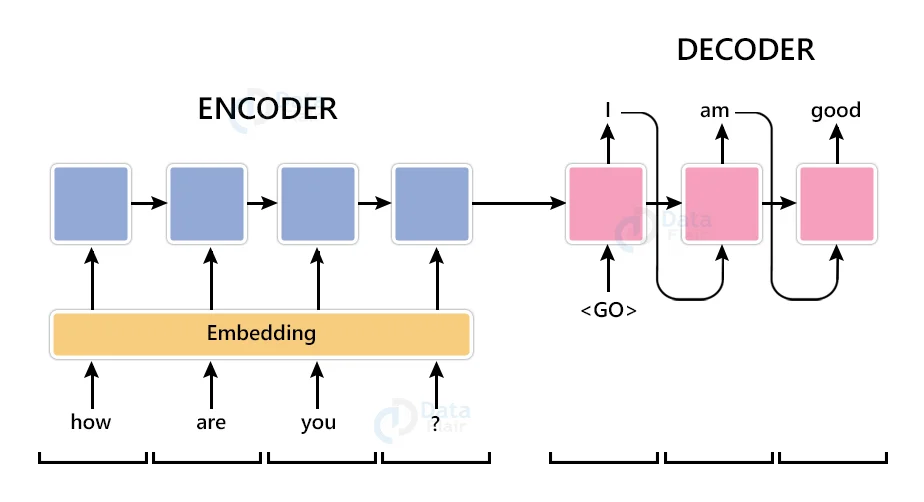

### 1.2.3 Attention Mechanism:

Let’s take an example to understand the Attention Mechanism. So below is the input text(review) and target text(summary).

Input text: Now that I’ve learned about machine learning, I’d like to work on some projects. Can someone recommend the best source for machine learning projects?

Target text: DataFlair is the best source for machine learning projects.

As you can see, we have passed the input text into the model. Rather than focusing on the whole word which is very difficult to remember, we will only focus on specific words for the prediction. In our example, we will only focus on the words like ‘source’, ‘machine learning’ and ‘projects’ to predict the target text.

There are two classes of Attention Mechanisms.

a) Global Attention :
B) Local Attention

### Global Attention:

In Global attention, all the hidden states of every time step from the encoder model is used to generate the context vector.

### Local Attention:

In Local attention, some of the hidden states from the encoder model is used to generate the context vector.

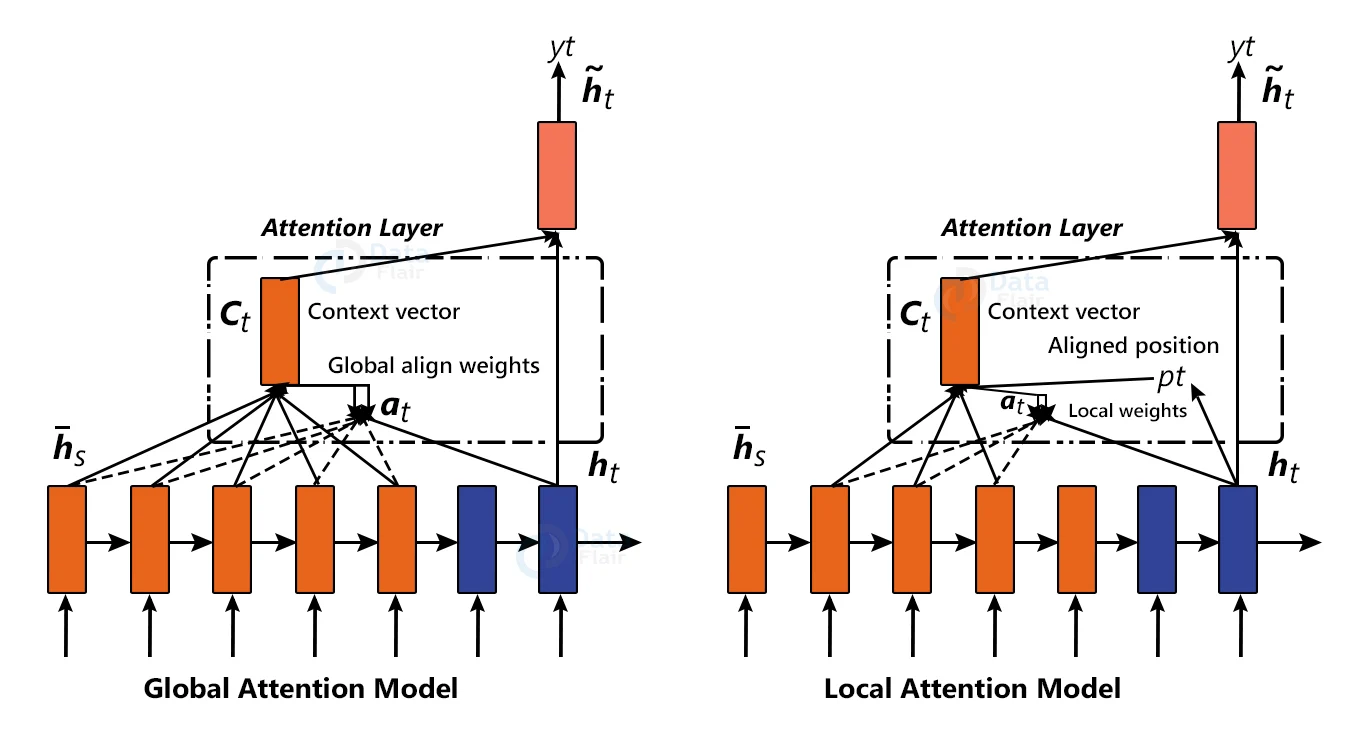

# 2 Project Prerequisites:
This project requires you to have a good knowledge of Python, Deep Learning, and Natural Language Processing(NLP). You can install all the modules for this project using following command:

In [ ]:
!pip install numpy
!pip install pandas
!pip install nltk
!pip install tensorflow
!pip install sklearn
!pip install bs4
!pip install pickle ##No need to install pickle, already installed along with Python 3.x.
## Import pickle and voila!
!pip install pydot
!pip install graphviz

## 2.1 Import Libraries

In [2]:
#DataFlair Project
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import graphviz

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lsreeram\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lsreeram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lsreeram\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.2 Parse the Datafile

We will traverse to the dataset file i.e. ‘ Reviews.csv ’ and extract all the input and target texts. For this we will be using the first 1,00,000 rows of our dataset for the training and testing part. It can be changed as per requirements. Our input will be the ‘Text’ column which is the review column and target will be the ‘Summary’ column. We will also drop the duplicate records and NA values from our dataframe.

In [4]:
#read the dataset file for text Summarizer
df=pd.read_csv("Reviews.csv",nrows=100000)
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

### 2.2.1 Pre-processing

Real-world texts are incomplete and they cannot be sent directly to the model that will cause certain errors. So, we clean all our texts and convert them into a presentable form for prediction tasks. So, firstly we will initialize all the variables and methods.

In [7]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
#contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

Some of our texts are in html format and contain html tags so first we will parse this text and remove all the html tags using ‘BeautifulSoup library’. After that, we tokenize our texts into words. And also check the following conditions:

1) contains integers
2) are less than 3 characters or
3) they are in stop words

If one of the above conditions matches, we will remove that particular word from the list of input or target words.

In [12]:
def clean(texts,src):
    #remove the html tags
    texts = BeautifulSoup(texts, "lxml").text
    #tokenize the text into words 
    words=word_tokenize(texts.lower())
    #filter words which contains \ 
    #integers or their length is less than or equal to 3
    words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
    #contraction file to expand shortened words
    #words= [contractions[w] if w in contractions else w for w in words ]
    #stem the words to their root word and filter stop words
    if src=="inputs":
        words= [stemm.stem(w) for w in words if w not in stop_words]
    else:
        words= [w for w in words if w not in stop_words]
    return words

### 2.2.2 Stemming

In [13]:
## We will add ‘sos’ to the start and ‘eos’ at the end of target text to tell our model that this is the starting and ending of sentences.
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Now after cleaning the sentences we will filter duplicate words and sort them accordingly. Also we will store the total number of input and target words.

In [14]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  32198
number of target words :  14170
maximum input length :  74
maximum target length :  17


### 2.2.3 Splitting the records

Split the dataset records into training and testing sets. We will be splitting in the 80:20 ratio where 80% record will be for training sets and 20% for testing sets.

In [15]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

### Text Vectorization

We will convert our word into integer sequence using vectorization technique.

For example,

L = [ ‘what doing’, ‘how are you’, ’good ’]

Tokenize all the elements of list ‘L’ and make a dictionary having key as tokens and value as the counter number. So after the data is fit we get a dictionary as

D = { ‘what’ : 1 , ‘doing’ :2 , ‘how’ : 3 , ‘are’ : 4 , ‘you’ :5 , ‘good’ : 6 }

So we have fit our data, now let’s transform the below list ‘J’ into integer sequence using our tokenizer.

J = [ ‘what are you doing’, ‘you are good’ ]

Transformed (Vectorized) J : [ [ 1 , 4 , 5 , 2 ] , [ 5 , 4 , 6 ] ]

In [16]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

After converting to integer sequence we will also make all the input and target texts to the same length for our model. So we will take the length of input sentences which has the highest frequency and store it in the ‘max_in_length’ variable, and repeat the same for target data also. Now we will pad arrays of 0’s to the texts if it is less than the assigned maximum input length.

Our encoder input data will be padded ‘x_train’ and decoder input data will be padded ‘y_train’ but we will not include the last word i.e ‘eos’. Decoder target data will be same as decoder input data but it will be one timestep ahead as it will not include the start word i.e. ‘sos’ of our target sentence.

In [17]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# 3 Build the Model

We are using Stacked LSTM containing 3 layers of LSTM stacked on top of each other. This will make our prediction much better. As per your requirement, you can have more also. Let’s understand our encoder model and decoder model.

## 3.1 Encoder

We will initialize the encoder input tensor using the ‘Input’ object. The expected shape of the batch will be 74 (maximum input length)-dimensions. Then we will create an ‘Embedding Layer’ which will have the total number of input words as the first argument and a shape of 500 which is the latent(hidden) dimension.

In [18]:
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

## 3.2 LSTM

Now we will create 3 stacked LSTM layers where the first LSTM layer will have input of encoder and like that create a continuous sequence of LSTM layers.

The LSTM layer will capture all the contextual information present in the input sequence. We will return hidden state output and also states i.e. hidden state and cell state after execution of every LSTM layer.

In [19]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

## 3.3 Decoder

Like Encoder we will initialize the decoder input tensor and then pass it to the only LSTM. Here, the decoder will also have the initial state where we will pass the hidden state and cell state values that we have obtained from the encoder’s LSTM layer.

In [20]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

## 3.4 Attention layer

We will pass the encoder and decoder outputs into the attention layer and then we will concatenate attention layer outputs with the decoder outputs.

In [21]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

Now we will create our Dense Layer that is the output layer for our model. It will have the shape of the total number of target words and a softmax activation function.

In [22]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge) 

## 3.5 Train the model

Finally, we will initialize our Model class with input and output data from the encoder and decoder layers. We can plot the model layers and also get the summary of our model.

In [25]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 500)      16099500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                            

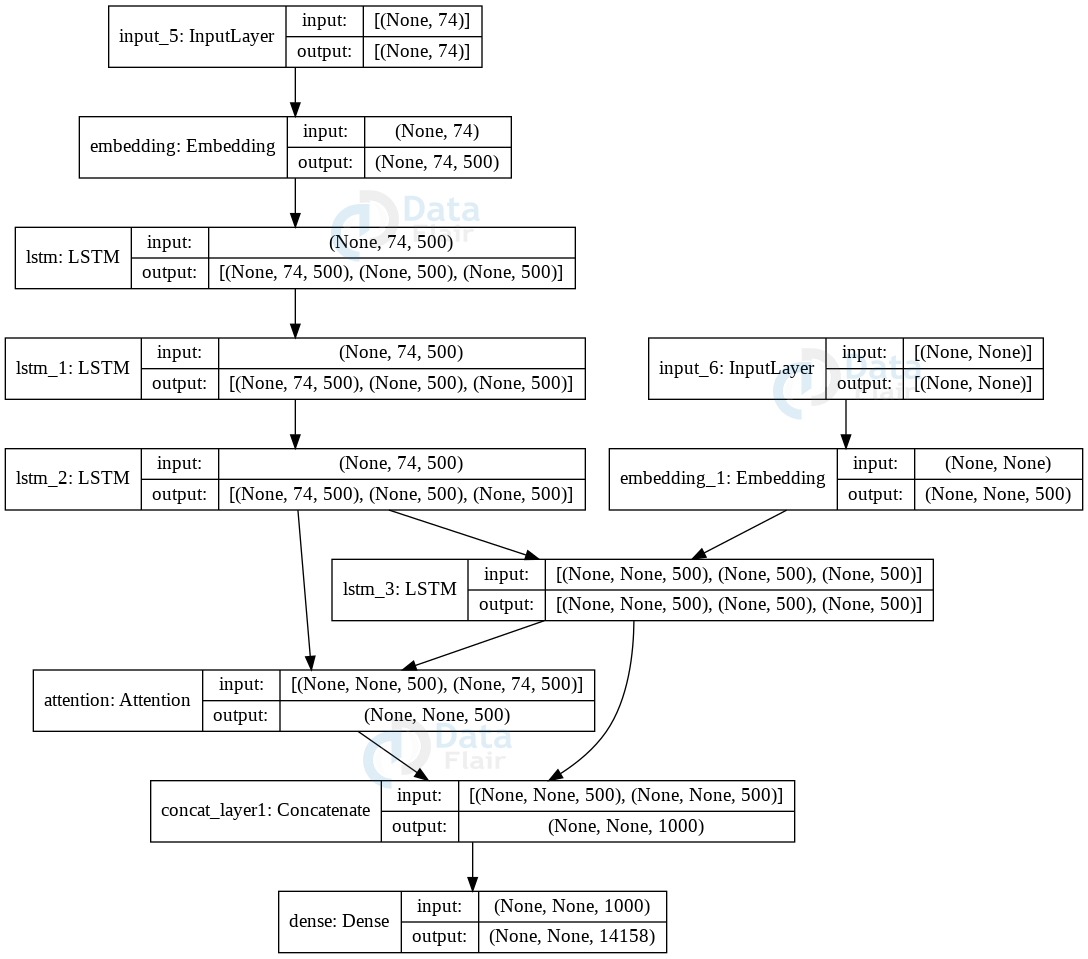

We will pass the data and train our model with ‘512’ batch size, epoch of ‘10’ and we will be using ‘RMSprop’ Optimizer to train our model. You can increase or decrease the epoch but take care of the validation loss.

In [26]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=512, 
    epochs=10, 
    validation_split=0.1,
    )
 
#Save model
model.save("s2s")

Epoch 1/10
125/125 [==============================] - 1893s 15s/step - loss: 1.7876 - accuracy: 0.7696 - val_loss: 1.4459 - val_accuracy: 0.7820
Epoch 2/10
125/125 [==============================] - 2119s 17s/step - loss: 1.3403 - accuracy: 0.8253 - val_loss: 1.3175 - val_accuracy: 0.8298
Epoch 3/10
125/125 [==============================] - 2070s 17s/step - loss: 1.3035 - accuracy: 0.8314 - val_loss: 1.2998 - val_accuracy: 0.8333
Epoch 4/10
125/125 [==============================] - 2073s 17s/step - loss: 1.2995 - accuracy: 0.8314 - val_loss: 1.2990 - val_accuracy: 0.8333
Epoch 5/10
125/125 [==============================] - 2045s 16s/step - loss: 1.2960 - accuracy: 0.8316 - val_loss: 1.2927 - val_accuracy: 0.8333
Epoch 6/10
125/125 [==============================] - 2020s 16s/step - loss: 1.2931 - accuracy: 0.8314 - val_loss: 1.2946 - val_accuracy: 0.8334
Epoch 7/10
125/125 [==============================] - 1983s 16s/step - loss: 1.3071 - accuracy: 0.8308 - val_loss: 1.2880 - val_ac

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


After our model gets trained we will get a directory as ‘s2s/’ with ‘saved_model.pb’ which includes optimizer, losses, and metrics of our model. The weights are saved in the variables/ directory.

## 4 Inference Model

We will be using the saved model to create an inference architecture for the encoder and decoder model. The inference model is used to test the new sentences for which the target sequence is not known.

### Encoder Inference

Input for the inference encoder model will be 0th layer i.e. Input object that we have created ( you can check it from the above summary and model plot ) and output will be the output of the last LSTM which is the 6th layer.

In [28]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("s2s")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

### Decoder Inference

Same as the Encoder inference model we will get the input, embedding, and LSTM layers from the saved model. Initialize the decoder hidden input and the other two states with the shape of latent (hidden) dimensions.

In [29]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

### Attention inference

In our case, the 8th layer is the attention layer. We will fetch it and pass the inference decoder output with the hidden state-input that we have initialized earlier. Then we will concatenate the decoder output with the attention layer output.

In [30]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

And same for the Dense layer (output layer) which is the 10th layer of our saved model. Initialize the Inference Model class with the above data.

In [31]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

Encode the input sequence as state vectors. Create an empty array of the target sequence and generate the start word i.e ‘sos’ in our case for every pair. Use this state value along with the input sequence to predict the output index. Use reverse target word index to get the word from the output index and append to the decoded sequence.

In [37]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '
 
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
            stop_condition = True
            #update target sequence to the current word index.
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = word_index
            en_h, en_c = dec_h, dec_c
            #return the decoded sentence
    return decoded_sentence

Assign the index of our word to the target sequence so for the next iteration our target sequence will be having a vector of the previous word. Iterate until our word is equal to the last word i.e ‘eos’ in our case or max length of the target text.

Finally, we have done all the processes and now we can predict the summary for the input review.

In [47]:
inp_review = input("Enter : ")
print('Review :', inp_review)
inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Enter : Since Republic of Tea discontinued their Bing Cherry Vanilla tea, I was looking for a replacement.  The flavor of this tea is very different from Republics - it's better.  The smell is very rich, like toasted vanilla and cherry.  It almost has a coffee smell, but not quite.  I don't like coffee, but this tea is incredible.  Glad I found it.  Best of all, the price!
Review : Since Republic of Tea discontinued their Bing Cherry Vanilla tea, I was looking for a replacement.  The flavor of this tea is very different from Republics - it's better.  The smell is very rich, like toasted vanilla and cherry.  It almost has a coffee smell, but not quite.  I don't like coffee, but this tea is incredible.  Glad I found it.  Best of all, the price!
1/1 [==============================] - 0s 22ms/step

Predicted summary: best best best best 




## Summary

In this project, we have developed a Text Summarizer model which generates the summary from the provided review using the LSTM model and Attention Mechanism. We got an accuracy of 87.82% which is good as we have taken only 1,00,000 records for training and testing sets.